* https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
* Detect anomalies in S&P 500 daily closing price. Build LSTM Autoencoder Neural Net for anomaly detection using Keras and TensorFlow 2.
* Our data is the daily closing prices for the S&P 500 index from 1986 to 2018.

In [1]:
dataset = '/Users/robin/kaggle/S&P500 Daily Prices 1986 - 2018/spx.csv'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv(dataset, parse_dates=['date'], index_col='date')

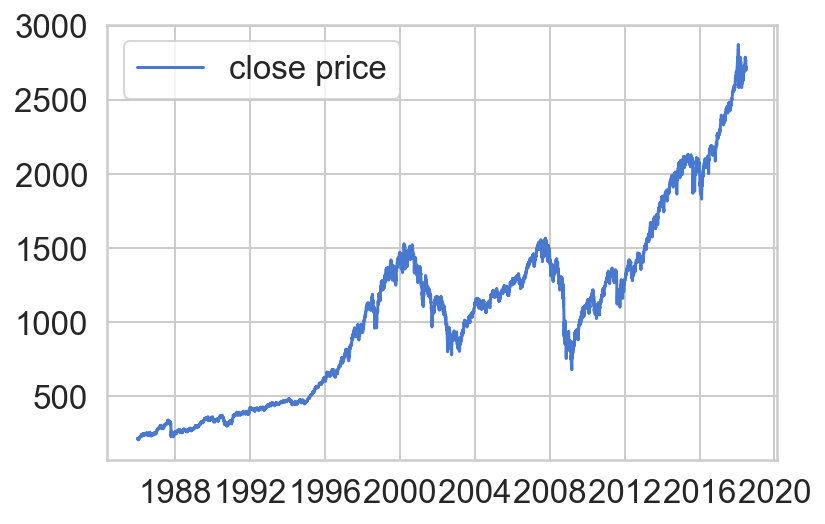

In [4]:
plt.plot(df, label='close price')
plt.legend();

We’ll use 95% of the data and train our model on it:

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


Next, we’ll rescale the data using the training data and apply the same transformation to the test data:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/Users/robin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/robin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Finally, we’ll split the data into subsequences. Here’s the little helper function for that:

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

We’ll create sequences with 30 days worth of historical data:

In [8]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


## LSTM Autoencoder in Keras

Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. Here’s how to build such a simple model in Keras:

In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 6976 samples, validate on 776 samples
Epoch 1/10
6976/6976 [==============================] - 12s 2ms/sample - loss: 0.1672 - val_loss: 0.1805
Epoch 2/10
6976/6976 [==============================] - 6s 887us/sample - loss: 0.0915 - val_loss: 0.2030
Epoch 3/10
6976/6976 [==============================] - 8s 1ms/sample - loss: 0.0953 - val_loss: 0.1347
Epoch 4/10
6976/6976 [==============================] - 6s 918us/sample - loss: 0.0841 - val_loss: 0.1933
Epoch 5/10
6976/6976 [==============================] - 6s 803us/sample - loss: 0.0831 - val_loss: 0.1902
Epoch 6/10
6976/6976 [==============================] - 6s 824us/sample - loss: 0.0852 - val_loss: 0.2339
Epoch 7/10
6976/6976 [==============================] - 6s 881us/sample - loss: 0.0836 - val_loss: 0.1758
Epoch 8/10
6976/6976 [==============================] - 6s 841us/sample - loss: 0.0845 - val_loss: 0.1352
Epoch 9/10
6976/6976 [==============================] - 6s 804us/sample - loss: 0.0776 - val_loss: 0.1390
Ep

## Evaluation

We’ve trained our model for 10 epochs with less than 8k examples. Here are the results:

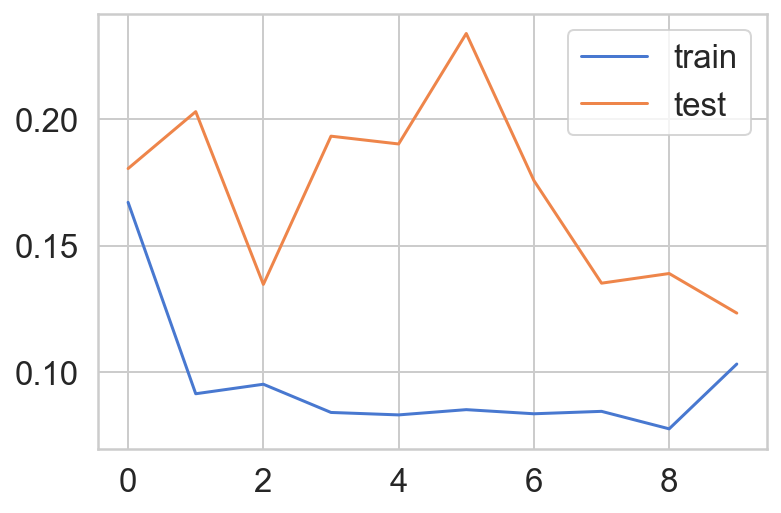

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Finding Anomalies

Still, we need to detect anomalies. Let’s start with calculating the Mean Absolute Error (MAE) on the training data:

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

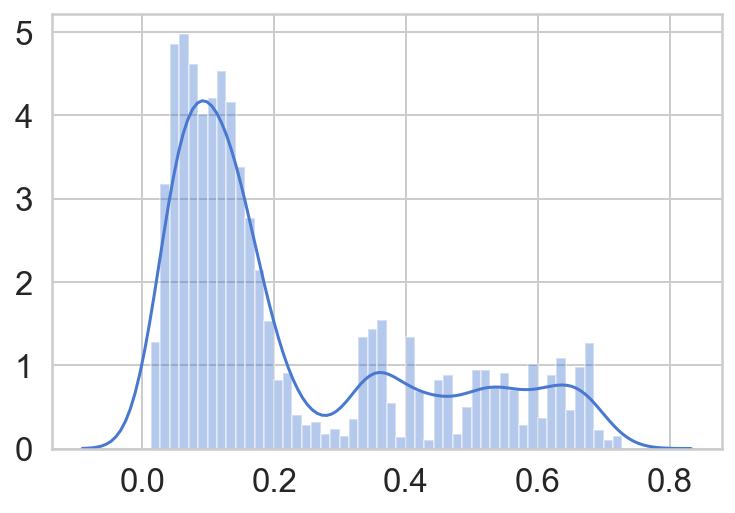

In [13]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [14]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

We’ll pick a threshold of 0.65, as not much of the loss is larger than that. When the error is larger than that, we’ll declare that example an anomaly:

In [15]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

In [16]:
test_score_df.head()

,loss,threshold,anomaly,close
date,,,,
2016-12-27,0.222185,0.65,False,2.392816
2016-12-28,0.222950,0.65,False,2.357204
2016-12-29,0.235088,0.65,False,2.355964
2016-12-30,0.241779,0.65,False,2.336373
2017-01-03,0.251939,0.65,False,2.372061


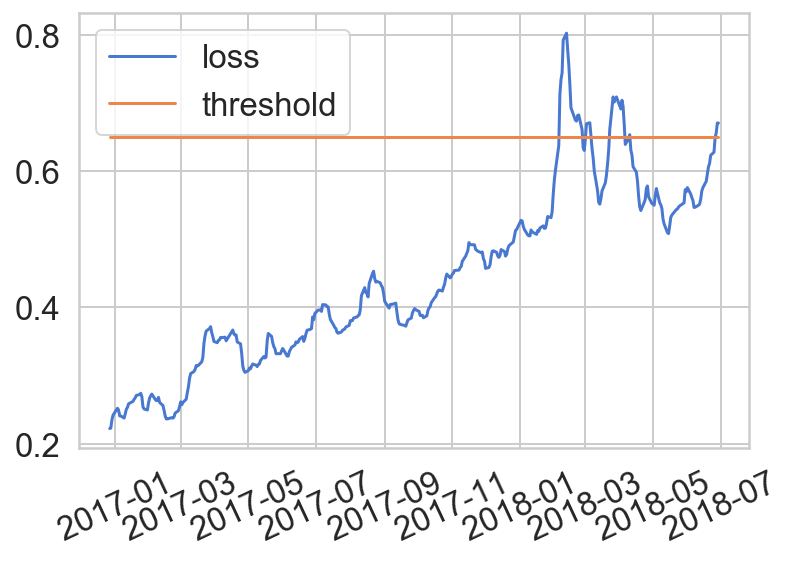

In [17]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [18]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.712378,0.65,True,3.193456
2018-02-07,0.734422,0.65,True,3.168136
2018-02-08,0.744130,0.65,True,2.979068
2018-02-09,0.792437,0.65,True,3.051476
2018-02-12,0.802513,0.65,True,3.119939


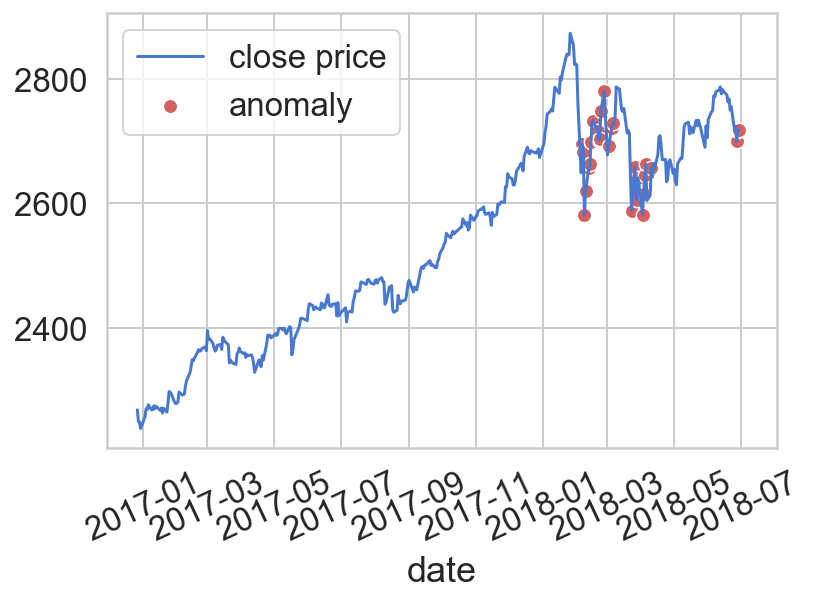

In [19]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

You should have a thorough look at the chart. The red dots (anomalies) are covering most of the points with abrupt changes to the closing price. You can play around with the threshold and try to get even better results.

## Conclusion

You just combined two powerful concepts in Deep Learning - LSTMs and Autoencoders. The result is a model that can find anomalies in S&P 500 closing price data. You can try to tune the model and/or the threshold to get even better results.